In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import math
import msprime
import numpy as np
import pandas as pd
import PTA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', 100)

from IPython.display import SVG, display
from PTA import jmsfs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
simfile = "./default_PTA/2D-test-SIMOUT.csv"
dat = pd.read_csv(simfile, sep=" ")
len(dat)

4400

In [61]:

idx = dat.columns.get_loc('0')

params = dat.iloc[:, :idx]
jmsfs = dat.iloc[:, idx:]

# Choose the input params
#p = params["r_moderns_mean"].astype(str)
p = params["r_moderns_mean"].astype(str) + ", " + params["Ne_s_mean"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(jmsfs, p, test_size=0.25)
np.shape(X_train)

(3300, 2205)

In [62]:
clf = RandomForestClassifier(max_depth=5)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [63]:
y_pred = cross_val_predict(clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_pred)

array([[754,   0, 101,   0],
       [  0, 382,   0, 430],
       [167,   0, 646,   0],
       [  0, 365,   0, 455]])

In [49]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[237,   0,  61,   0],
       [  0, 176,   0,  80],
       [ 32,   0, 231,   0],
       [  0, 179,   0, 104]])

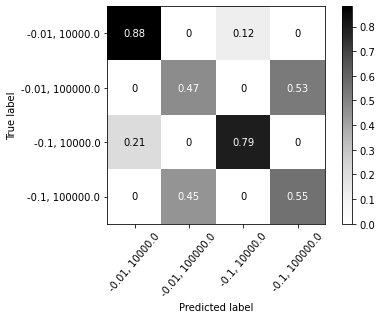

In [85]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, labels=clf.classes_,
                                        cmap="Greys", xticks_rotation=50, normalize='true')


## Slow

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{diabetes.feature_names[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

## Predict Ne_average from constant size simulations

In [76]:
const_dat = pd.read_csv("./default_PTA/ConstantSize-SIMOUT.csv", sep=" ")
idx = const_dat.columns.get_loc('0')

const_params = const_dat.iloc[:, :idx]
const_jmsfs = const_dat.iloc[:, idx:]

# Choose the input params
const_p = const_params["Ne_s_mean"]

const_X_train, const_X_test, const_y_train, const_y_test = train_test_split(const_jmsfs, const_p, test_size=0.25)
print(np.shape(const_X_train))

rgr = RandomForestRegressor(max_depth=5)
rgr.fit(const_X_train, const_y_train)

const_y_pred = cross_val_predict(rgr, const_X_train, const_y_train, cv=3)


(7500, 2205)


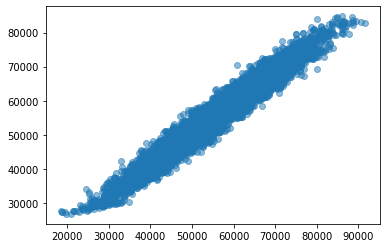

In [82]:
plt.scatter(const_y_train, const_y_pred, alpha=0.5)

## Predict r_modern_mu & sigma given normal r_modern and fixed/constant Ne_anc

In [100]:
variable_dat = pd.read_csv("./default_PTA/VariableRModern-SIMOUT.csv", sep=" ")
idx = variable_dat.columns.get_loc('0')

variable_params = variable_dat.iloc[:, :idx]
variable_jmsfs = variable_dat.iloc[:, idx:]

# Choose the input params
variable_p = variable_params[["r_modern_mu", "r_modern_sigma"]]

variable_X_train, variable_X_test, variable_y_train, variable_y_test = train_test_split(variable_jmsfs, variable_p, test_size=0.25)
print(np.shape(variable_X_train))

rgr = RandomForestRegressor(max_depth=5, njobs=-1)
rgr.fit(variable_X_train, variable_y_train)

variable_y_pred = cross_val_predict(rgr, variable_X_train, variable_y_train, cv=3)


(14999, 2205)


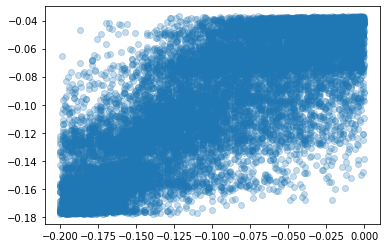

In [101]:
# Predicting mu and sigma
t = "r_modern_mu"
plt.scatter(variable_y_train[t], variable_y_pred[:, 0], alpha=0.25)

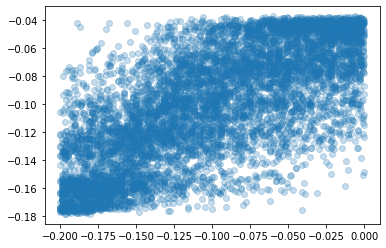

In [88]:
# Predicting mu alone
plt.scatter(variable_y_train, variable_y_pred, alpha=0.25)

In [102]:
from sklearn.metrics import *
r2_score(variable_y_train, variable_y_pred, multioutput='raw_values')

array([0.59528716, 0.46148669])